In [125]:
!pip install mysql-connector-python

In [126]:
#importing matplot
import matplotlib.pyplot as plt 

#importing numpy
import numpy as np 

# Set plot space as inline for inline plots display
%matplotlib inline

In [127]:
# importing pandas into jupyter notebook
import pandas as pd
#importing SQL connector
import mysql.connector

con = mysql.connector.connect(user='hbs-student', password='super-secure-password?',
                              host='hbs-ds-060120.c1doesqrid0e.us-east-1.rds.amazonaws.com',
                              database='movies')

In [128]:
#importing Box office database
# box_m = pd.read_sql_query('select * from bom_movie_gross', con)
df = pd.read_sql_query("""
                         SELECT  title, studio, bom_movie_gross.domestic_gross, 
                                 foreign_gross, year, tconst, runtime_minutes, genres, 
                                 averagerating, numvotes, directors, writers, production_budget
                         FROM movies.bom_movie_gross
                         JOIN imdb_title_basics
                         ON title = primary_title
                         JOIN imdb_title_ratings
                         USING (tconst)
                         JOIN imdb_title_crew
                         USING (tconst)
                         JOIN tn_movie_budgets
                         ON title = movie;
                         """, con)


In [153]:
df.head()

,title,studio,domestic_gross,foreign_gross,year,tconst,runtime_minutes,genres,averagerating,numvotes,directors,writers,production_budget
839,Jackpot,DR,800.0,1100000.0,2014,tt3309662,132.0,"Comedy,Thriller",2.1,647,nm0004072,"nm0004072,nm3728294","$400,000"
840,Jackpot,DR,800.0,1100000.0,2014,tt4320966,92.0,Comedy,6.7,55,nm0629006,nm3293255,"$400,000"
841,Jackpot,DR,800.0,1100000.0,2014,tt8671762,150.0,"Comedy,Romance",7.8,18,nm8390573,nm3829341,"$400,000"
838,Jackpot,DR,800.0,1100000.0,2014,tt1809231,86.0,"Action,Comedy,Crime",6.6,2941,nm0994368,"nm0994368,nm1867674","$400,000"
649,Khumba,MNE,1000.0,27200000.0,2013,tt1487931,85.0,"Adventure,Animation,Family",5.7,4984,nm1950075,"nm3567652,nm1950075,nm0731271,nm3823153,nm0221...","$15,000,000"


In [130]:
st_do1 = df[df[year] == 2012]
st_do = st_do1.groupby('studio').sum()
st_do = st_do.domestic_gross.sort_values(ascending=False)
st_do = st_do.head(15)
st_do.reset_index()

NameError: name 'year' is not defined

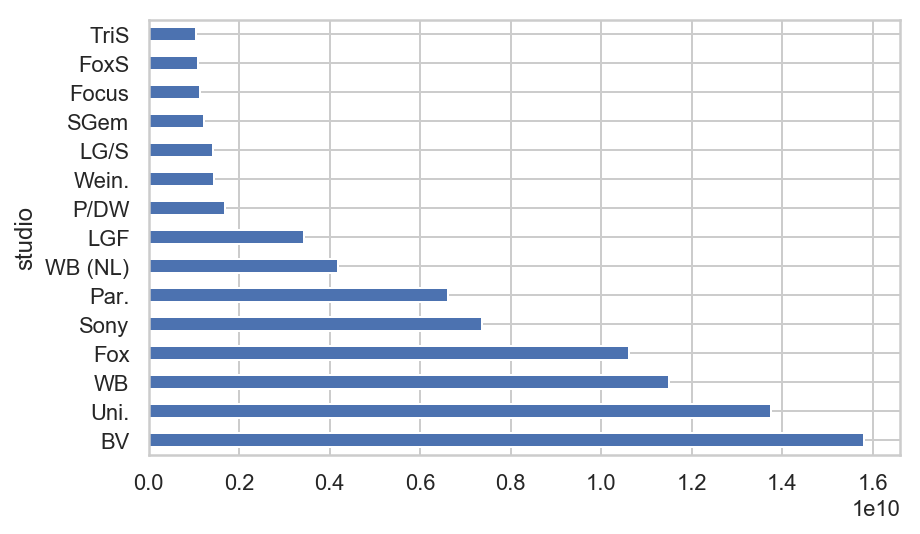

In [133]:
sns.set(style="whitegrid")
st_do.plot(x='studio', y = ['domestic_gross'], kind = 'barh', color='b')
plt.show()

In [211]:
df.groupby('genres').sum()

,domestic_gross,foreign_gross,year,runtime_minutes,averagerating,numvotes
genres,,,,,,
,4.575000e+08,6.907110e+08,14086,355.0,42.8,110
Action,1.845175e+08,4.559000e+08,16116,401.0,46.5,59721
"Action,Adventure",1.180000e+04,0.000000e+00,2014,103.0,5.8,6955
"Action,Adventure,Animation",2.473191e+09,4.358100e+09,30205,1501.0,110.7,2985941
"Action,Adventure,Biography",2.400000e+08,4.467000e+08,6048,374.0,21.5,763936
"Action,Adventure,Comedy",2.784300e+09,4.749200e+09,36280,2027.0,121.6,5370363
"Action,Adventure,Crime",4.729000e+08,8.226000e+08,18125,955.0,56.0,1182024
"Action,Adventure,Drama",1.867124e+09,3.606289e+09,52353,3047.0,159.2,3918376
"Action,Adventure,Family",5.336000e+08,9.753000e+08,10065,531.0,28.2,765559


In [212]:
df.genres.value_counts()

Drama                         100
Adventure,Animation,Comedy     63
Comedy,Drama,Romance           53
Comedy,Drama                   52
Action,Adventure,Sci-Fi        45
Comedy                         41
Drama,Romance                  39
Comedy,Romance                 36
Documentary                    33
Action,Comedy,Crime            30
Action,Crime,Drama             29
Action,Adventure,Fantasy       28
Horror,Mystery,Thriller        27
Drama,Thriller                 26
Action,Adventure,Drama         26
Biography,Drama,History        22
Action,Crime,Thriller          21
Crime,Drama,Thriller           21
Horror                         20
Horror,Thriller                20
Biography,Comedy,Drama         18
Action,Adventure,Comedy        18
Biography,Drama                17
Action,Thriller                17
Crime,Drama                    16
Action,Adventure,Animation     15
Drama,Horror,Mystery           13
Action,Adventure,Thriller      13
Crime,Drama,Mystery            13
Action,Drama,T

# Analysis of most successfull genres by revenue and IMDB ratings 2012

In [154]:
import seaborn as sns
import scipy.stats as st
import math

In [193]:
# Data cleansing

# Movies with bottom 25% of # votes will be excluded as these are less known and could skew the results
highly_rated_movies = df[df.numvotes >1.298000e+04]
highly_rated_movies = highly_rated_movies[highly_rated_movies.year == 2012]

# Data cleaning as sum of genre creates duplicates
highly_rated_movies["rating_helper_column"] = highly_rated_movies.apply(lambda row: row.year / 2012 ,axis=1)
highly_rated_movies = highly_rated_movies.groupby('genres').sum()
highly_rated_movies["year"] = highly_rated_movies.apply(lambda row: row.year / row.rating_helper_column ,axis=1)
highly_rated_movies["domestic_gross"] = highly_rated_movies.apply(lambda row: row.domestic_gross / row.rating_helper_column ,axis=1)
highly_rated_movies["foreign_gross"] = highly_rated_movies.apply(lambda row: row.foreign_gross / row.rating_helper_column ,axis=1)
highly_rated_movies["averagerating"] = highly_rated_movies.apply(lambda row: row.averagerating / row.rating_helper_column ,axis=1)
highly_rated_movies["runtime_minutes"] = highly_rated_movies.apply(lambda row: row.runtime_minutes / row.rating_helper_column ,axis=1)
highly_rated_movies.groupby('genres').sum()


,domestic_gross,foreign_gross,year,runtime_minutes,averagerating,numvotes,rating_helper_column
genres,,,,,,,
Action,1.560000e+07,4.099999e+06,2012.0,95.000000,5.400000,58185,1.0
"Action,Adventure,Animation",1.034000e+08,2.035000e+08,2012.0,97.000000,7.300000,145281,1.0
"Action,Adventure,Comedy",1.039000e+08,2.314000e+08,2012.0,94.000000,5.800000,83507,1.0
"Action,Adventure,Crime",7.250000e+07,5.465000e+07,2012.0,108.500000,6.700000,330162,2.0
"Action,Adventure,Drama",8.170000e+07,6.969725e+07,2012.0,119.750000,6.325000,583338,4.0
"Action,Adventure,Fantasy",8.370000e+07,2.216000e+08,2012.0,99.000000,5.700000,172330,1.0
"Action,Adventure,Sci-Fi",2.021250e+08,3.077500e+08,2012.0,135.250000,6.650000,1787993,4.0
"Action,Adventure,Thriller",1.675333e+08,3.990000e+08,2012.0,127.000000,7.033333,1138483,3.0
"Action,Comedy,Crime",8.240000e+07,3.680000e+07,2012.0,100.000000,6.250000,516244,2.0


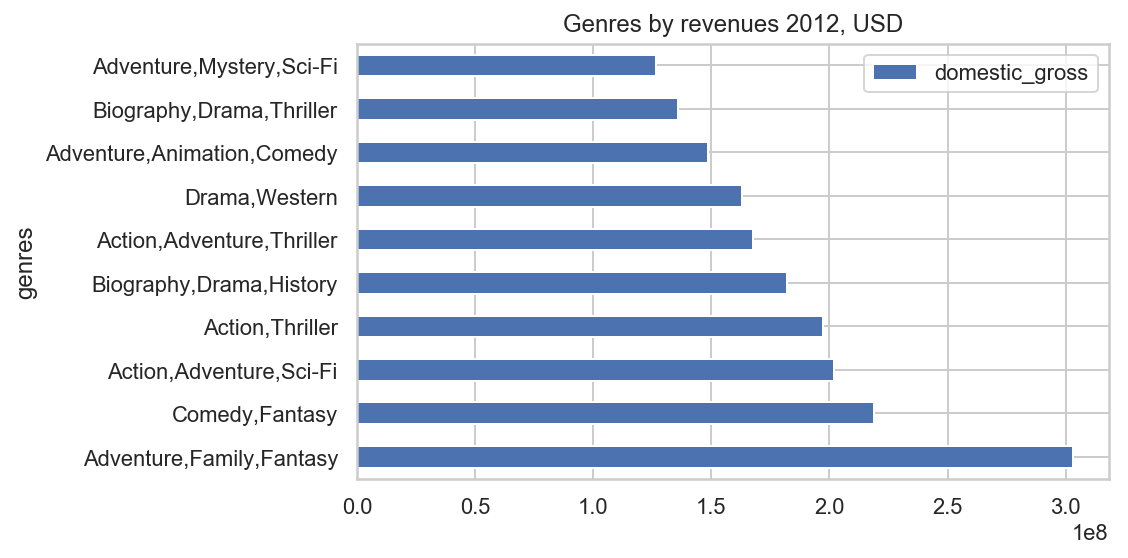

In [183]:
# Plot top 10 genres by revenue as a bar chart
popular_movies = highly_rated_movies.domestic_gross.sort_values(ascending=False)
popular_movies = popular_movies.head(10)
popular_movies.plot(x='genres', y = ['domestic_gross'], kind = 'barh', color='b')
plt.title("Genres by revenues 2012, USD")
plt.legend()
plt.show()

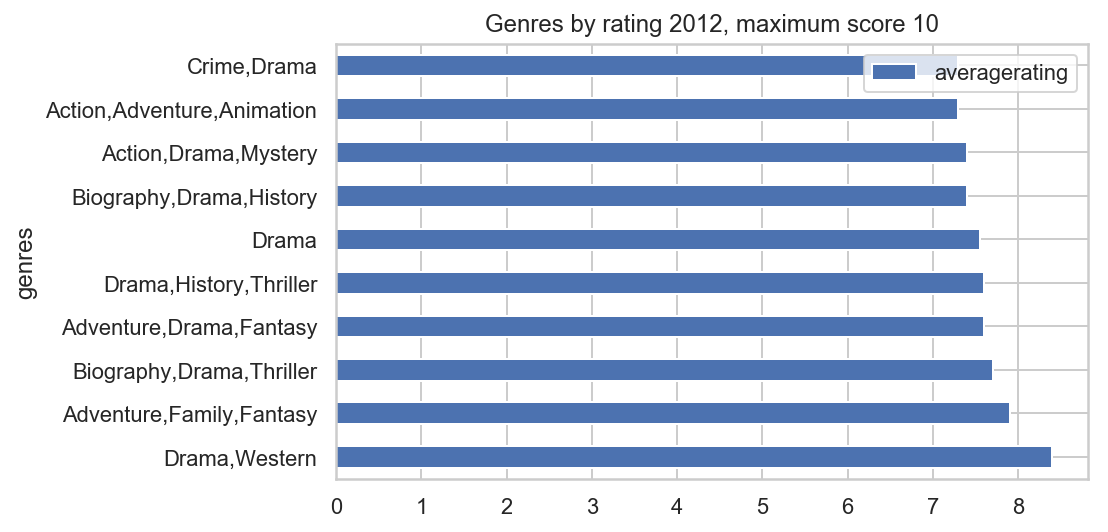

In [184]:
# Plot top 10 genres by ratings 
highly_rated = highly_rated_movies.averagerating.sort_values(ascending=False)
highly_rated = highly_rated.head(10)
highly_rated.plot(x='genres', y = ['averagerating'], kind = 'barh', color='b')
plt.title("Genres by rating 2012, maximum score 10")
plt.legend()
plt.show()

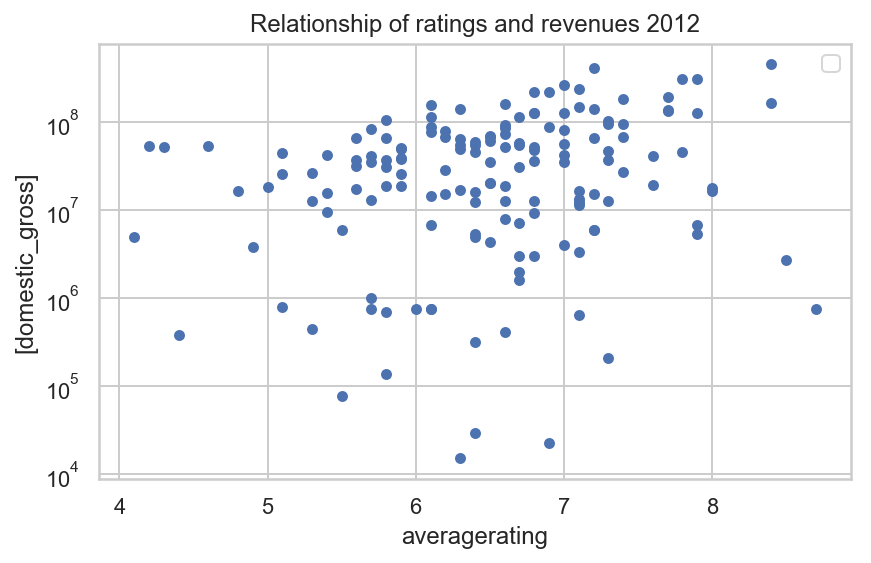

In [201]:
# Plot relationship of ratings and gross revenues 2012
popularity_revenue_relationship = df[df.year == 2012]
popularity_revenue_relationship
popularity_revenue_relationship.plot(x='averagerating', y = ['domestic_gross'], kind = 'scatter',logy=True, color='b')
plt.title("Relationship of ratings and revenues 2012")
plt.legend()
plt.show()

In [205]:
df.describe()

,domestic_gross,foreign_gross,year,runtime_minutes,averagerating,numvotes
count,1.474000e+03,1.265000e+03,1475.000000,1443.000000,1475.000000,1.475000e+03
mean,5.986040e+07,1.000169e+08,2013.743051,107.223839,6.433356,1.123550e+05
std,8.358186e+07,1.521061e+08,2.528483,19.678566,1.021585,1.619922e+05
min,8.000000e+02,1.000000e+00,2010.000000,3.000000,1.600000,5.000000e+00
25%,7.200000e+06,1.080000e+07,2011.000000,94.000000,5.900000,1.298000e+04
50%,3.335000e+07,4.000000e+07,2014.000000,105.000000,6.500000,5.895500e+04
75%,7.370000e+07,1.119000e+08,2016.000000,118.000000,7.100000,1.376310e+05
max,7.001000e+08,9.464000e+08,2018.000000,192.000000,9.200000,1.841066e+06
